In [5]:
from __future__ import print_function
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib
#import pandas_profiling
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 8)
pd.options.display.float_format = '{:.2f}'.format

In [95]:
fn = 'train.csv'
df = pd.read_csv(fn)

Оценим кол-во данных и отсутвующие данные

In [8]:
df.count()

PassengerId    891
Survived       891
Pclass         891
Name           891
Sex            891
Age            714
SibSp          891
Parch          891
Ticket         891
Fare           891
Cabin          204
Embarked       889
dtype: int64

Оценим числовые характеристики датасета

In [9]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.00,891.00,891.00,714.00,891.00,891.00,891.00
mean,446.00,0.38,2.31,29.70,0.52,0.38,32.20
std,257.35,0.49,0.84,14.53,1.10,0.81,49.69
min,1.00,0.00,1.00,0.42,0.00,0.00,0.00
25%,223.50,0.00,2.00,20.12,0.00,0.00,7.91
50%,446.00,0.00,3.00,28.00,0.00,0.00,14.45
75%,668.50,1.00,3.00,38.00,1.00,0.00,31.00
max,891.00,1.00,3.00,80.00,8.00,6.00,512.33


* PassengerId - для построения модели не нужен
* Pclass - есть всего 3 класса
* Age - есть пустые значения, вероятно способность выжить зависит от возраста, преобразуем его в список значений (<10, <15, <25, <40, < 55 )
* SibSp - наличие родствнников по горизонтали
* Parch - наличие родственников по вертикали, можно объединить с предыдущим полем
* Fare - стоимость билета, отражают статус пассажиров, есть вероятность что пассажиры с одинаковой стоимостью одного класса, держались вместе, определим уровень богатства разбив на группы (10, 30, 100, 600)



In [51]:
bins = [0, 10, 15, 25, 40, 55, 100]
labels = [10, 15, 25, 40, 55, 100 ]
mn = df['Age'].mean()
df['AgeGrp'] = df['Age'].fillna(mn)
df['AgeGrp'] = pd.cut(df['AgeGrp'], bins, labels=labels)
df[['Age', 'AgeGrp']].sample(10)

,Age,AgeGrp
369,24.00,25
237,8.00,10
515,47.00,55
766,nan,40
834,18.00,25
401,26.00,40
295,nan,40
131,20.00,25
198,nan,40
216,27.00,40


In [69]:
bins = [0, 10, 30, 100, 600]
labels = [10, 30, 100, 600 ]
mn = df['Fare'].mean()
df['FareGrp'] = df['Fare'].fillna(mn)
df['FareGrp'] = pd.cut(df['FareGrp'], bins, labels=labels)
df[['Fare', 'FareGrp']].sample(10)

,Fare,FareGrp
340,26.00,30
339,35.50,100
6,51.86,100
363,7.05,10
647,35.50,100
273,29.70,30
565,24.15,30
447,26.55,30
692,56.50,100
803,8.52,10


Нечисловые поля
* Cabin          - каюта, есть информация о каютах у 25%  пассажиров, вероятно знакомы и помогают друг другу
* Embarked       - порт отправления, тоже определяет вероятность знакомства
* Name           - полагаю исключить из модели
* Sex            - нужно приобразовать в бинарный вид

In [10]:
df[df['Cabin'].isnull()==False].head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.00,1,0,PC 17599,71.28,C85,C
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00,1,0,113803,53.10,C123,S
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.00,0,0,17463,51.86,E46,S
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.00,1,1,PP 9549,16.70,G6,S
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.00,0,0,113783,26.55,C103,S


Проанализируем зависимости выживаемости от параметров

In [22]:
df.groupby('Sex').agg({'Survived':'sum', 'Age':['mean', 'median'], 
                       'Fare': 'mean', 'PassengerId': 'count',
                       'Pclass': 'mean'
                      })

Survived   Age         Fare PassengerId Pclass
            sum  mean median  mean       count   mean
Sex                                                  
female      233 27.92  27.00 44.48         314   2.16
male        109 30.73  29.00 25.52         577   2.39

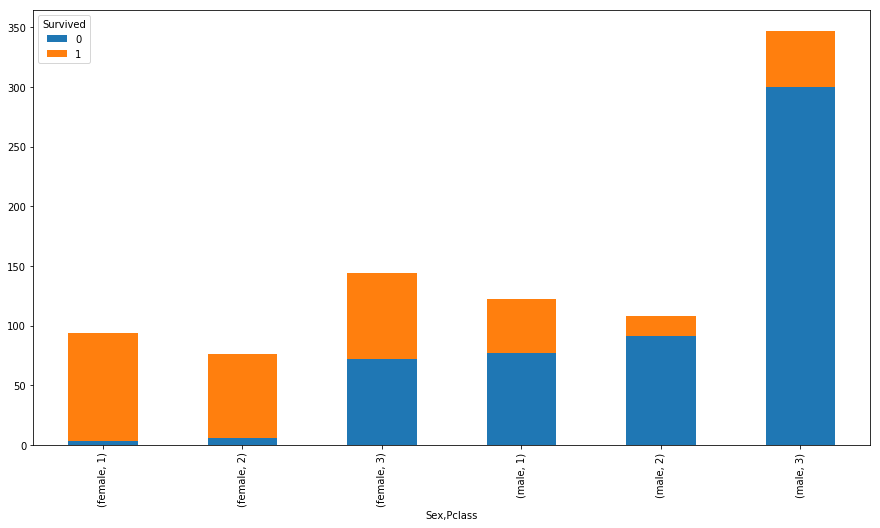

In [33]:
df.groupby(['Sex','Pclass', 'Survived']).size().unstack().plot(kind='bar', stacked=True);

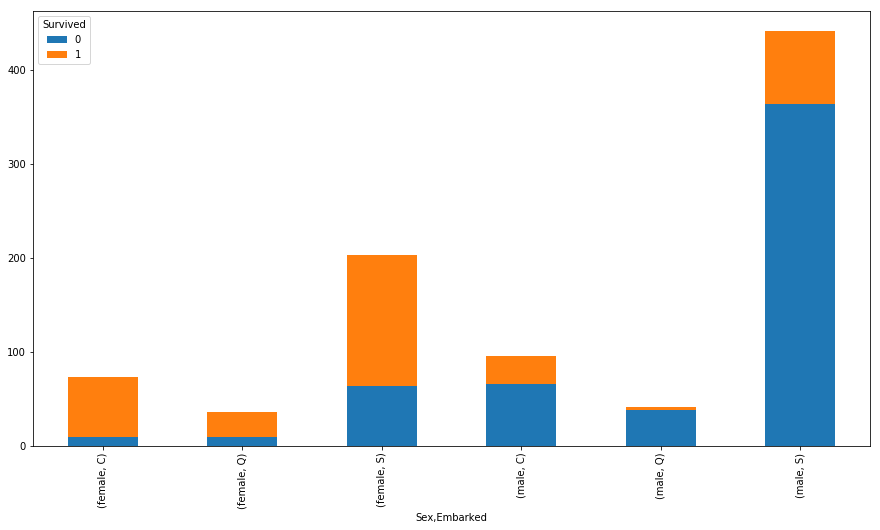

In [34]:
df.groupby(['Sex','Embarked', 'Survived']).size().unstack().plot(kind='bar', stacked=True);

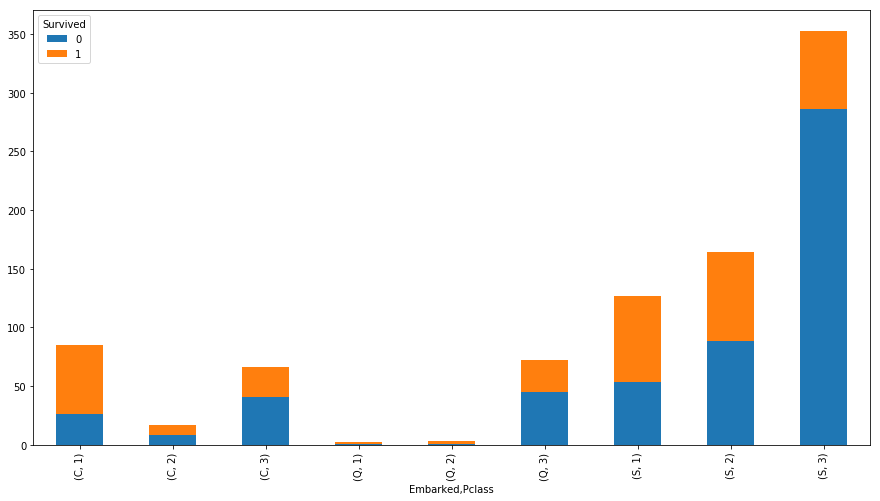

In [35]:
df.groupby(['Embarked','Pclass', 'Survived']).size().unstack().plot(kind='bar', stacked=True);

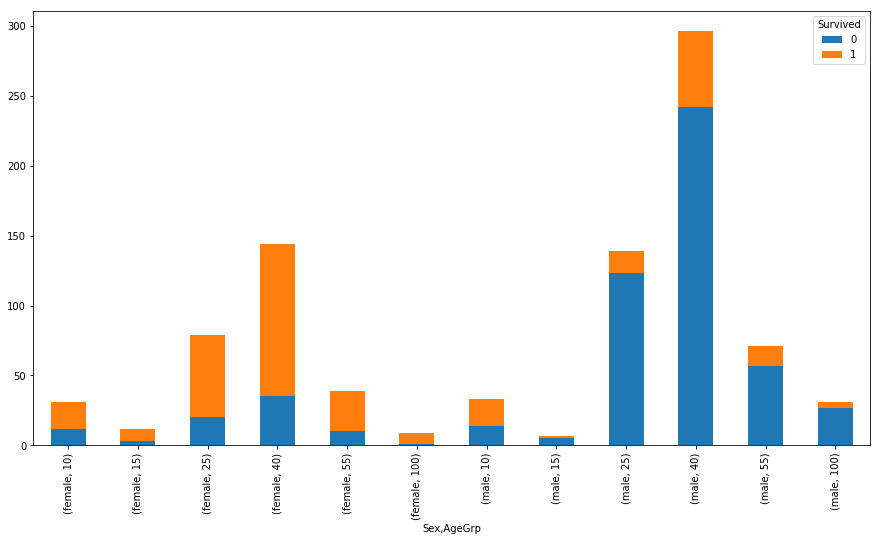

In [52]:
df.groupby(['Sex','AgeGrp', 'Survived']).size().unstack().plot(kind='bar', stacked=True);

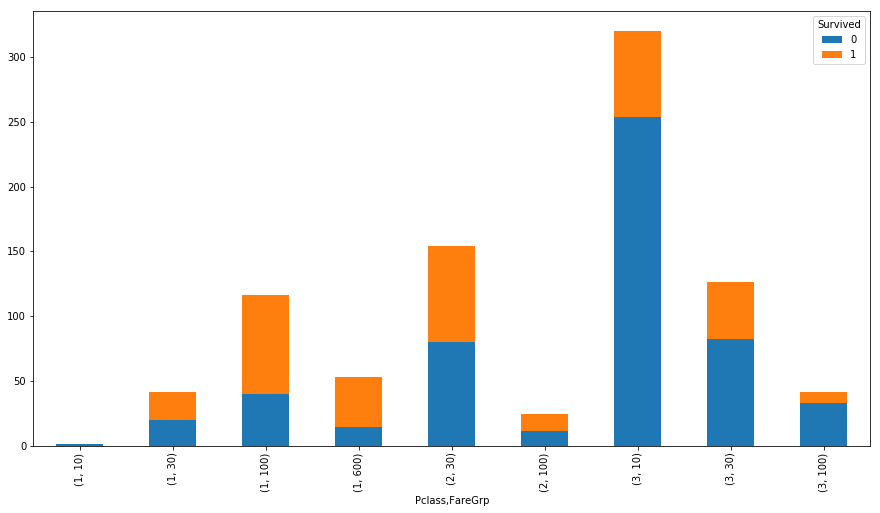

In [70]:
df.groupby(['Pclass','FareGrp', 'Survived']).size().unstack().plot(kind='bar', stacked=True);

Исходя из полученных данных можно увидеть возможности для группировки (объединения полей), но для начал можно попробовать с несколькими полями

Проведем преобразование к цифрому и матричному виду
и сделаем преобразования порта и класса к полям

In [196]:
from sklearn.pipeline import make_union, make_pipeline
from sklearn.preprocessing import FunctionTransformer, LabelEncoder, MinMaxScaler, Imputer, LabelBinarizer, OneHotEncoder,StandardScaler
from sklearn.feature_extraction import DictVectorizer

def get_sex_col(df):
    lb= LabelBinarizer()
    return lb.fit_transform(df[['Sex']])

def get_num_cols(df):
    return df[['Age', 'Fare']]

def get_pclass_col(df):
    return df[['Pclass']]

def get_port_col(df):
    le = LabelEncoder()
    return le.fit_transform(df['Embarked'].fillna('S').T).reshape(-1, 1).astype('int')


def get_cabin_col(df):
    le = LabelEncoder()
    return le.fit_transform(df['Cabin'].fillna('NaN').T).reshape(-1, 1).astype('float')

# наличие родственников можно объединить
def get_rel_col(df):
    return np.sum(df[['SibSp','Parch']] , axis=1).values.reshape(-1, 1).astype('float')  

pipeline = make_union(*[
    make_pipeline(FunctionTransformer(get_num_cols, validate=False), Imputer(strategy='mean'), MinMaxScaler()),
    make_pipeline(FunctionTransformer(get_pclass_col, validate=False), OneHotEncoder(sparse=False)),
    make_pipeline(FunctionTransformer(get_sex_col, validate=False)),
    make_pipeline(FunctionTransformer(get_port_col, validate=False), OneHotEncoder(sparse=False)),
    make_pipeline(FunctionTransformer(get_cabin_col, validate=False), StandardScaler()),
    make_pipeline(FunctionTransformer(get_rel_col, validate=False), StandardScaler())
])


In [197]:
y_train = df_train['Survived']
y_train.shape

(891,)

In [198]:
x_train = pipeline.fit_transform(df_train)
x_train.shape

(891, 11)

In [213]:
from sklearn.linear_model import LogisticRegressionCV
lr = LogisticRegressionCV(cv=10)
lr.fit(x_train, y_train)
lr

LogisticRegressionCV(Cs=10, class_weight=None, cv=10, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [214]:
df_train = df.copy()

In [215]:
from sklearn.metrics import accuracy_score
accuracy_score(y_train, lr.predict(x_train))

0.80920314253647585

In [216]:
from sklearn.linear_model import SGDClassifier, RidgeClassifierCV
sgd = SGDClassifier()
sgd.fit(x_train, y_train)
sgd

/home/lucky/bigdata/venv/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [217]:
accuracy_score(y_train, sgd.predict(x_train))

0.75308641975308643

In [218]:
rdg = RidgeClassifierCV(alphas=(0.01, 0.1, 1.0))
rdg.fit(x_train, y_train)
rdg

RidgeClassifierCV(alphas=(0.01, 0.1, 1.0), class_weight=None, cv=None,
         fit_intercept=True, normalize=False, scoring=None)

In [1]:
accuracy_score(y_train, rdg.predict(x_train))

NameError: name 'y_train' is not defined

In [220]:
df_test = pd.read_csv('test.csv')
x_test = pipeline.fit_transform(df_test) 
x_test.shape

(418, 11)

In [221]:
y_test = lr.predict(x_test)

In [222]:
df_predicted = pd.DataFrame({'PassengerId': df_test['PassengerId'], 'Survived': y_test})

In [223]:
df_predicted.to_csv('sample_submission.csv', sep=',', index=False)